# El Niño vs La Niña

## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import os.path as op
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import df2img

from myst_nb import glue 

sys.path.append("../../../../indicators_setup")
from ind_setup.colors import get_df_col, plotting_style
from ind_setup.tables import plot_df_table
from ind_setup.plotting_int import plot_oni_index_th
from ind_setup.plotting import plot_bar_probs_ONI, add_oni_cat

plotting_style()
from ind_setup.core import fontsize

sys.path.append("../../../functions")
from data_downloaders import GHCN, download_oni_index

## Define location and variables of interest

In [2]:
country = 'Palau'

## Observations from Koror Station

The data used for this analysis comes from the GHCN (Global Historical Climatology Network)-Daily database. <br>
This a database that addresses the critical need for historical daily temperature, precipitation, and snow records over global land areas. GHCN-Daily is a
composite of climate records from numerous sources that were merged and then subjected to a suite of
quality assurance reviews. The archive includes over 40 meteorological elements including temperature daily maximum/minimum, temperature at observation time,
precipitation and more.

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

In [3]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [4]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

In [5]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_min = GHCN.extract_dict_data_var(GHCND_dir, 'TMIN', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    dict_max = GHCN.extract_dict_data_var(GHCND_dir, 'TMAX', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    st_data = pd.concat([dict_min['data'], (dict_max['data'])], axis=1).dropna()
    st_data['TMIN'] = np.where(st_data['TMIN'] >50, np.nan, st_data['TMIN'])
    st_data['diff'] = st_data['TMAX'] - st_data['TMIN']
    st_data['TMEAN'] = (st_data['TMAX'] + st_data['TMIN'])/2
    st_data.to_pickle(op.join(path_data, 'GHCN_surface_temperature.pkl'))
else:
    st_data = pd.read_pickle(op.join(path_data, 'GHCN_surface_temperature.pkl'))

## ONI index

The Oceanic Niño Index (ONI) is the standard measure used to monitor El Niño and La Niña events. It is based on sea surface temperature anomalies in the central equatorial Pacific (Niño 3.4 region) averaged over 3-month periods. 

https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

In [6]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'

In [7]:
df1 = download_oni_index(p_data)

In [8]:
lims = [-.5, .5]
plot_oni_index_th(df1, lims = lims)

In [9]:
st_data_monthly = st_data.resample('M').mean()
st_data_monthly.index = pd.DatetimeIndex(st_data_monthly.index).to_period('M').to_timestamp() + pd.offsets.MonthBegin(1)

In [10]:
df1['tmin'] = st_data_monthly['TMIN']
df1['tmax'] = st_data_monthly['TMAX']
df1['tdiff'] = df1['tmax'] - df1['tmin']
df1['tmean'] = (df1['tmax'] + df1['tmin'])/2
df1['tmean_ref'] = df1['tmean'] - df1.loc['1961':'1990'].tmean.mean()
df1['tmean_ref_min'] = df1['tmean'] - df1.groupby(df1.index.year).max().tmean.min()
df1 = add_oni_cat(df1, lims = lims)

The following bar plot represents the mean temperature anomalies with respect to the 1960-1990 climatology. The color of the bar represents wether it is a El Niño or La Niña year.

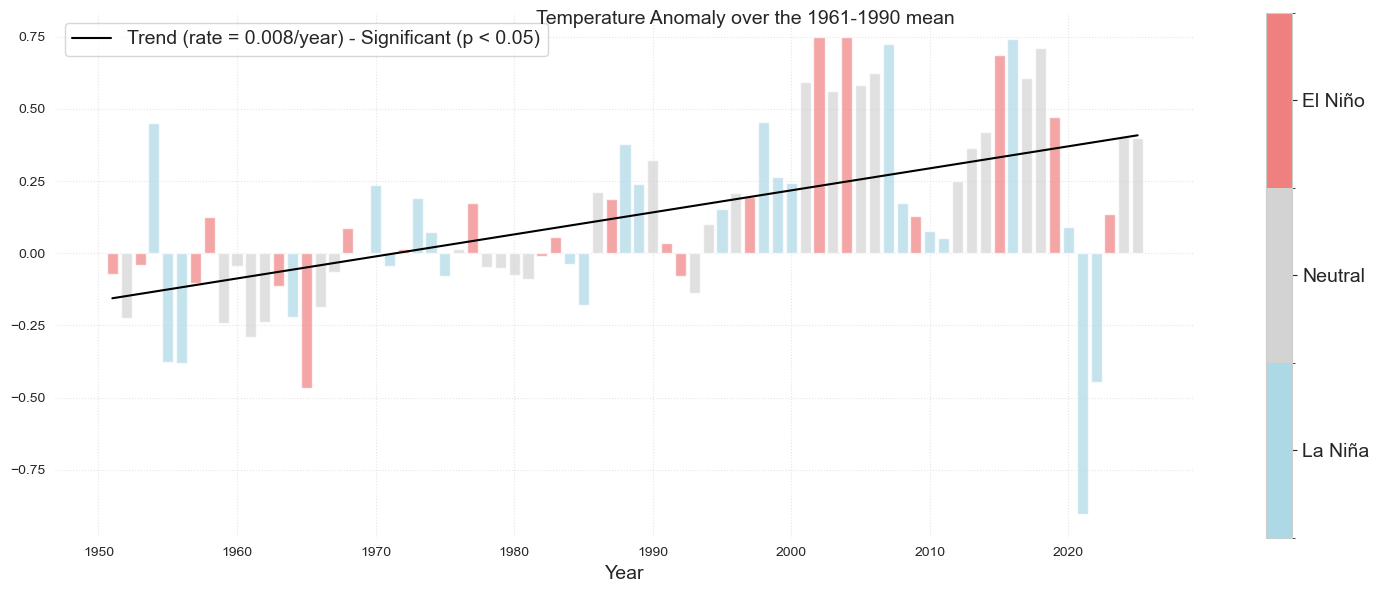

In [11]:
df2 = df1.resample('Y').mean()
fig = plot_bar_probs_ONI(df2, var='tmean_ref')
fig.suptitle('Temperature Anomaly over the 1961-1990 mean', fontsize = fontsize)
plt.savefig(op.join(path_figs, 'F2_ST_Mean.png'), dpi=300, bbox_inches='tight')


glue("fig_ninho", fig, display=False)
plt.show()

```{glue:figure} fig_ninho
:name: "fig_ninho"

Annual mean temperature anomalies relative to 1961–1990 climatology at Koror. The solid black line represents the trend, which is  statistically significant (p < 0.05).  Shading in the bar plots represent El Niño (red), La Niña (blue) and Neutral (grey) phases of ENSO as defined by values of the Oceanic Niño Index (ONI). 

```

In [13]:
df_format = np.round(df1.describe(), 2)

### Generate table
Table sumarizing different metrics of the data analyzed in the plots above

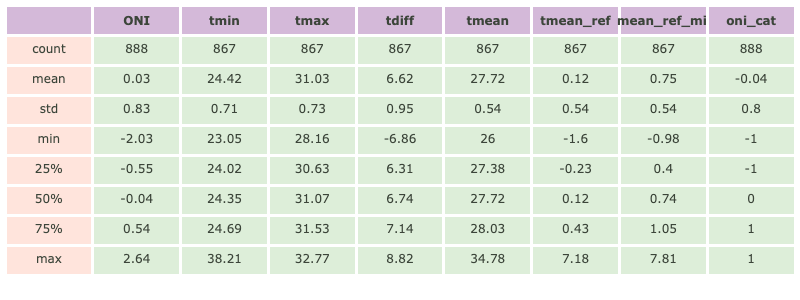

In [14]:
fig = plot_df_table(df_format)
df2img.save_dataframe(fig=fig, filename="getting_started.png")